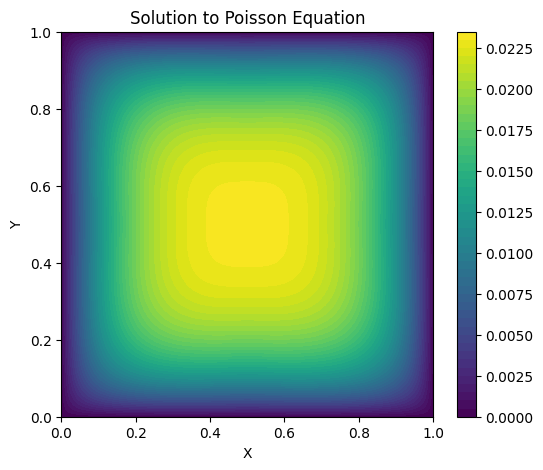

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg

N = 1000
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Define f
F = -np.abs(X-0.5) - np.abs(Y-0.5)

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)
F = F.ravel()

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F)
U = u.reshape((N, N))

# Plotting
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, U, 50, cmap='viridis')
plt.colorbar()
plt.title('Solution to Poisson Equation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()